# Precipitation daily data analysis

In [1]:
import glob
from datetime import datetime
import zipfile
import os
import re

import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_dataframe_from_zip(filename, date_parser):
    z = zipfile.ZipFile(filename)
    namelist = z.namelist()
    datafile = [x for x in namelist if x.startswith('produkt_')][0]
    df = pd.read_csv(z.open(datafile), delimiter=';', na_values=['', '-999'],
                     skip_blank_lines=True, skipinitialspace=True,
                     parse_dates=[1], date_parser=date_parser)
    df = df.rename(columns={x: x.strip() for x in df.columns})
    df = df[~df['MESS_DATUM'].isnull()]
    return df


def load_all_zips(pattern, date_parser):
    all_zips = glob.glob(pattern)
    zip_count = len(all_zips)
    for i, filename in enumerate(all_zips):
        print(filename)
        print('%d/%d - %2.f%%' % (i, zip_count, i / zip_count * 100.0), end="\r")
        try:
            yield get_dataframe_from_zip(filename, date_parser) 
        except zipfile.BadZipFile:
            print('%s is bad zip file, breaking!' % filename)
            break


def get_dataframe(filename, pattern, date_parser):
    if os.path.exists(filename):
        df = pd.read_csv(filename, compression='gzip')
        df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y-%m-%d')
        return df
    df = pd.concat(load_all_zips(pattern, date_parser))
    with gzip.open(filename, 'wt') as write_file:
        df.to_csv(write_file, encoding='utf-8')
    return df

df = get_dataframe('data.csv.gz', 'data/*.zip', lambda x: pd.to_datetime(x, format='%Y%m%d'))
df.head()

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSHOEHE_IND,SCHNEEHOEHE,eor
0,0,1,1912-01-01,1.0,0.0,0.0,NaN,eor
1,1,1,1912-01-02,1.0,0.2,1.0,NaN,eor
2,2,1,1912-01-03,1.0,0.0,0.0,NaN,eor
3,3,1,1912-01-04,1.0,1.0,1.0,NaN,eor
4,4,1,1912-01-05,1.0,2.1,7.0,NaN,eor


In [3]:
df.MESS_DATUM.describe()

count                96704603
unique                  83274
top       1989-09-19 00:00:00
freq                     4349
first     1781-01-01 00:00:00
last      2014-12-31 00:00:00
Name: MESS_DATUM, dtype: object

In [4]:
df.describe()

,Unnamed: 0,STATIONS_ID,QUALITAETS_NIVEAU,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSHOEHE_IND,SCHNEEHOEHE
count,9.670460e+07,9.670460e+07,9.670285e+07,9.665560e+07,9.665282e+07,6.208446e+07
mean,1.112022e+04,3.071004e+03,6.623787e+00,2.210732e+00,1.670325e+00,1.830763e+00
std,8.020738e+03,1.927524e+03,2.493168e+00,4.906684e+00,2.269350e+00,9.998241e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.639000e+03,1.546000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.758000e+03,3.028000e+03,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.627500e+04,4.486000e+03,9.000000e+00,2.300000e+00,4.000000e+00,0.000000e+00
max,8.327300e+04,1.547700e+04,1.000000e+01,3.120000e+02,8.000000e+00,7.800000e+02


In [5]:
len(df)

96704603

- 0	kein Niederschlag
- 1	nur Regen (in historischen Daten vor dem 01.01.1979)
- 4	Form des Niederschlages nicht bekannt, obwohl Niederschlag gemeldet
- 6	nur Regen
- 7	nur Schnee
- 8	Regen und Schnee und/oder Schneeregen
- 9	Fehlkennung

In [6]:
df.NIEDERSCHLAGSHOEHE_IND.value_counts()

0.0    47249957
1.0    20829508
4.0    19084244
6.0     4203137
7.0     3206754
8.0     2073686
5.0        2545
2.0        2171
3.0         817
Name: NIEDERSCHLAGSHOEHE_IND, dtype: int64

### Messwerte über die Jahre

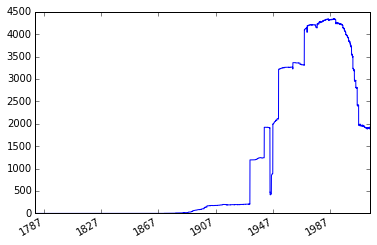

In [7]:
df.MESS_DATUM.value_counts().plot()

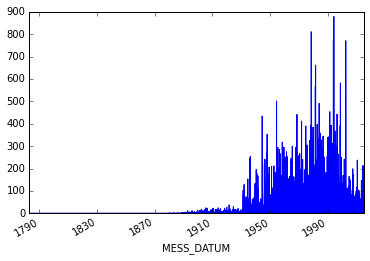

In [8]:
STARKREGEN_THRESHOLD = 40
df[df.NIEDERSCHLAGSHOEHE > STARKREGEN_THRESHOLD].groupby(['MESS_DATUM']).size().plot()

## Stations

Read in TXT file of stations (sadly read_csv failed me here, doing manual splitting).

In [7]:
# pd.read_csv('data/RR_Tageswerte_Beschreibung_Stationen.txt',
#             sep='\s+', comment='-', skipinitialspace=True, skiprows=2, header=None, engine='python')

SEP = re.compile('\s+')

def parse_stations(filename):
    header = None
    with open(filename, encoding='latin1') as f:
        for line in f:
            line = line.strip()
            if header is None:
                header = SEP.split(line)
                continue
            if line.startswith('-') or len(line) < 2:
                continue
            parts = SEP.split(line)
            if len(parts) > len(header):
                parts = parts[:6] + [' '.join(parts[6:-1])] + parts[-1:]
                assert(len(parts) == len(header))
            yield {k: v for k, v in zip(header, parts)}
                

stations = pd.DataFrame(parse_stations('data/RR_Tageswerte_Beschreibung_Stationen.txt'))
stations['sid'] = pd.to_numeric(stations['Stations_id'], errors='coerce')
stations['lat'] = pd.to_numeric(stations['geoBreite'], errors='coerce')
stations['lng'] = pd.to_numeric(stations['geoLaenge'], errors='coerce')
stations['height'] = pd.to_numeric(stations['Stationshoehe'], errors='coerce')
stations['von_datum'] = pd.to_datetime(stations['von_datum'], format='%Y%m%d')
stations['bis_datum'] = pd.to_datetime(stations['bis_datum'], format='%Y%m%d')
stations.head()

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
0,Baden-Württemberg,00001,478,Aach,1986-06-30,47.8413,8.8493,1912-01-01,1,47.8413,8.8493,478
1,Nordrhein-Westfalen,00002,138,Aachen (Kläranlage),2006-12-31,50.8066,6.0996,1951-01-01,2,50.8066,6.0996,138
2,Nordrhein-Westfalen,00003,202,Aachen,2011-03-31,50.7827,6.0941,1891-01-01,3,50.7827,6.0941,202
3,Nordrhein-Westfalen,00004,243,Aachen-Brand,1979-10-31,50.7683,6.1207,1951-01-01,4,50.7683,6.1207,243
4,Baden-Württemberg,00006,456,Aalen-Unterrombach,2016-02-27,48.8359,10.0597,1982-11-01,6,48.8359,10.0597,456


In [10]:
len(stations)

5521

### Station existence over time

In order to figure out how stations existed over time, plot them in a giant gantt chart.

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


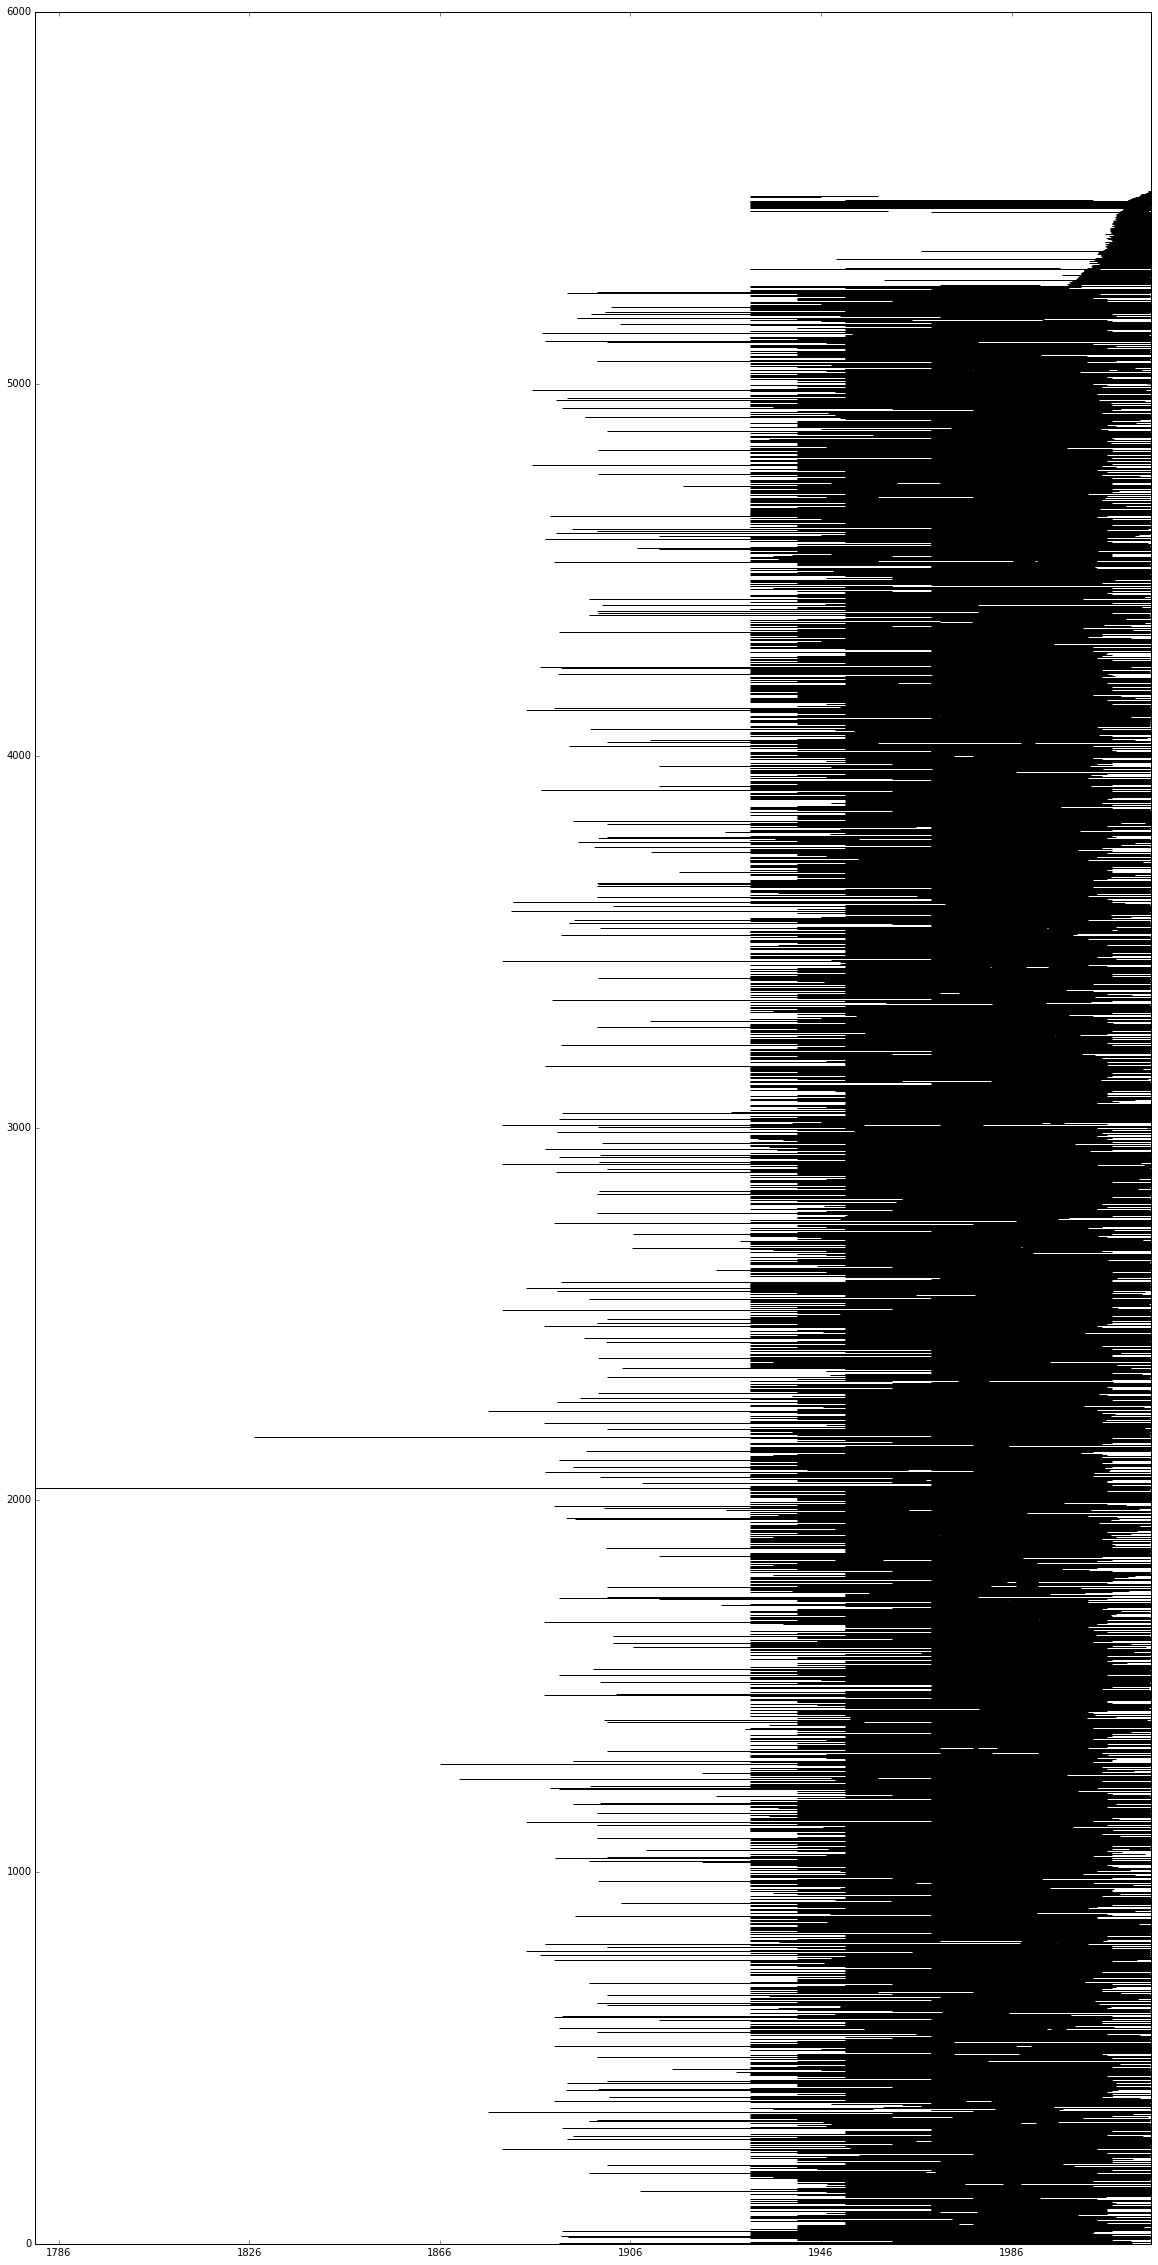

In [11]:
import matplotlib.dates as dt

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(stations.index, dt.date2num(stations.von_datum.astype(datetime)), dt.date2num(stations.bis_datum.astype(datetime)))

Station availability fluctuates, let's find the stations that are active between 1950 and 2014.

In [12]:
stations_1950_2014 = stations[(stations.von_datum.dt.year <= 1950) & (stations.bis_datum.dt.year >= 2014)]
len(stations_1950_2014)

843

Some Germany plotting code.

In [13]:
from mpl_toolkits.basemap import Basemap

germany_bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_map(df, vals='value', cmap='cool', diverging=False, bbox=germany_bbox):
    if diverging:
        vmin = df[vals].min()
        vmax = df[vals].max()
        midrange = 1 - vmax / (vmax + abs(vmin))
        cmap = shifted_color_map(matplotlib.cm.get_cmap(cmap), midpoint=midrange)
        
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .5 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap=cmap, c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m


/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


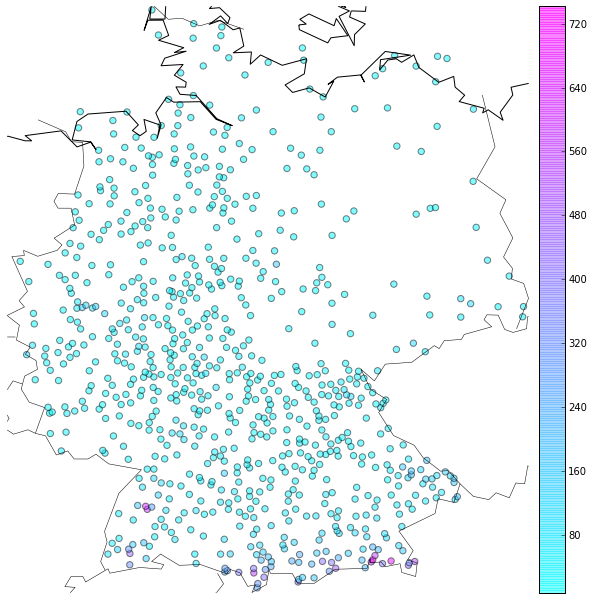

In [14]:
starkregen_df = df[df.NIEDERSCHLAGSHOEHE > STARKREGEN_THRESHOLD]
greater_40_map = stations_1950_2014[['sid', 'lng', 'lat']].merge(starkregen_df, left_on='sid', right_on='STATIONS_ID')
plot_map(greater_40_map.groupby(['lat', 'lng']).NIEDERSCHLAGSHOEHE.size().reset_index(), 0)

In [15]:
df_1950_2014 = df[df.STATIONS_ID.isin(stations_1950_2014['sid'])]
df_1950_2014 = df_1950_2014[df_1950_2014.MESS_DATUM.dt.year >= 1950]
len(df_1950_2014)

18159476

In [16]:
df_1950_2014_size = df_1950_2014[~df_1950_2014.NIEDERSCHLAGSHOEHE.isnull()].groupby(['STATIONS_ID']).size()
complete_stations = stations_1950_2014[stations_1950_2014.sid.isin(df_1950_2014_size[df_1950_2014_size >= 23741].index)]
len(complete_stations)

297

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


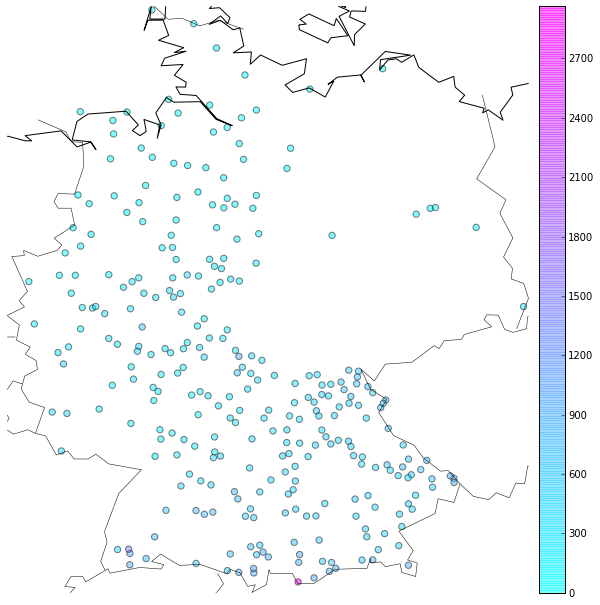

In [34]:
plot_map(complete_stations, 'height')

In [17]:
starkregen_date = df_1950_2014.groupby('MESS_DATUM').apply(lambda x: (x.NIEDERSCHLAGSHOEHE > STARKREGEN_THRESHOLD).any())

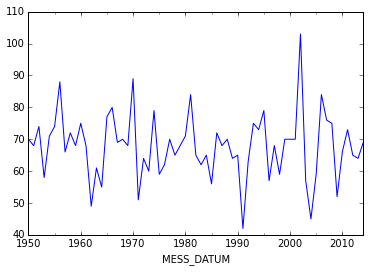

In [18]:
starkregen_date.resample('1A', how=np.sum).plot()

(0, 790.0)

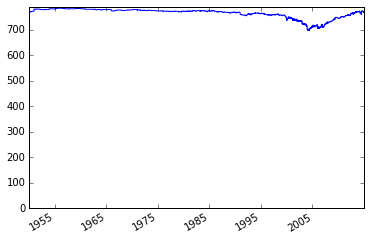

In [19]:
fig = df_1950_2014.MESS_DATUM.value_counts().plot()
plt.ylim(0)

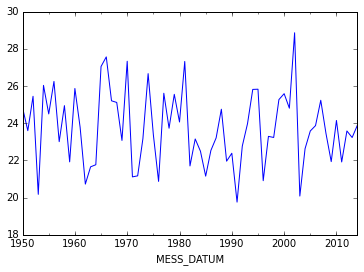

In [20]:
df_1950_2014.groupby('MESS_DATUM').NIEDERSCHLAGSHOEHE.max().resample('1A', how=np.mean).plot()

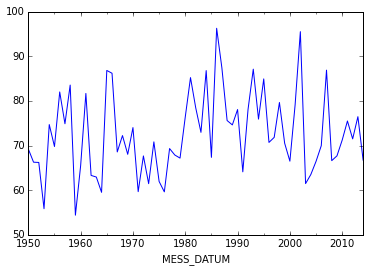

In [21]:
df_1950_2014[df_1950_2014.NIEDERSCHLAGSHOEHE > 10].groupby(['MESS_DATUM']).size().resample('1A').plot()

In [22]:
df_complete = df[(df.MESS_DATUM.dt.year > 1950) & (df.STATIONS_ID.isin(complete_stations.sid))]
df_complete.head()

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSHOEHE_IND,SCHNEEHOEHE,eor
404064,21007,23,1951-01-01,5,2.8,7,NaN,eor
404065,21008,23,1951-01-02,5,5.3,7,NaN,eor
404066,21009,23,1951-01-03,5,0.2,8,NaN,eor
404067,21010,23,1951-01-04,5,2.3,7,NaN,eor
404068,21011,23,1951-01-05,5,6.3,1,NaN,eor


In [23]:
station_date_group = df_complete.groupby(['MESS_DATUM', 'STATIONS_ID'])
(station_date_group.size() > 1).any()

False

In [24]:
station_values = station_date_group.NIEDERSCHLAGSHOEHE.sum().unstack()

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [25]:
station_values_99th = station_values.resample('1A', how=lambda x: np.percentile(x, q=99))
# station_values_99th = station_values_99th.set_index(station_values_99th.index.year)
station_values_99th.head()

STATIONS_ID,23,73,145,187,202,205,223,227,232,262,...,5785,5792,5803,5826,5831,5870,5906,5959,14303,14310
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1951-12-31,24.676,16.592,24.224,19.836,15.984,56.816,21.468,21.796,27.936,17.716,...,18.260,40.240,24.000,21.560,18.032,21.760,14.652,20.940,20.388,17.344
1952-12-31,16.170,17.785,20.170,22.385,17.495,44.760,18.045,25.280,18.035,22.150,...,19.880,39.440,29.850,17.590,18.245,17.605,16.635,19.220,21.970,20.455
1953-12-31,14.928,21.180,22.956,18.036,15.908,41.160,13.968,17.068,20.008,17.268,...,25.248,28.800,20.860,20.296,17.416,17.600,17.012,17.576,11.180,16.856
1954-12-31,22.804,20.360,26.808,22.136,17.840,91.772,19.428,23.696,26.836,29.400,...,17.336,68.424,31.584,21.400,22.936,22.856,13.952,23.040,17.652,25.668
1955-12-31,17.104,28.500,25.196,22.460,18.336,56.744,15.944,20.180,24.880,21.972,...,22.572,45.480,34.040,17.424,16.896,18.292,25.088,22.568,24.264,29.480


In [26]:
mean_99th_values = station_values_99th.T.mean()
mean_99th_values.head()

MESS_DATUM
1951-12-31    21.015125
1952-12-31    21.033889
1953-12-31    19.395367
1954-12-31    24.606397
1955-12-31    22.404687
Freq: A-DEC, dtype: float64

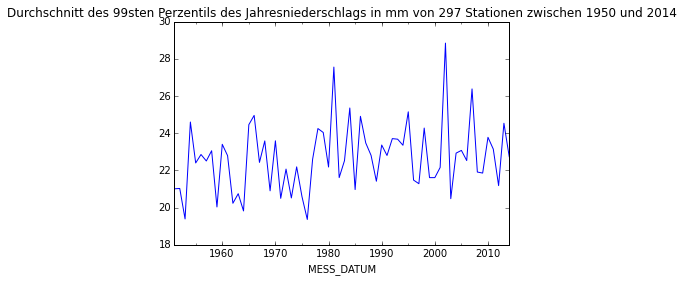

In [27]:
plt.title('Durchschnitt des 99sten Perzentils des Jahresniederschlags in mm von 297 Stationen zwischen 1950 und 2014')
mean_99th_values.plot()

In [28]:
mean_99th_values[:10].mean(), mean_99th_values[-10:].mean()

(22.033690909090943, 23.118096969696996)

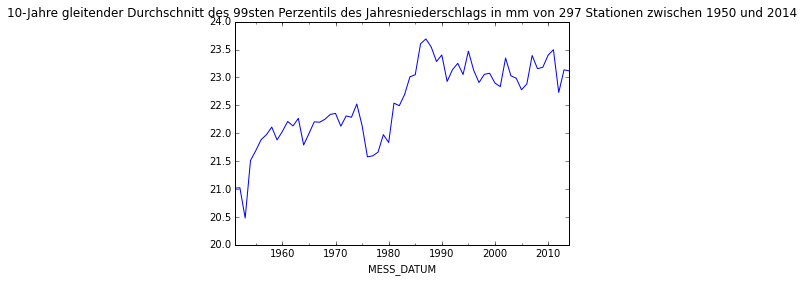

In [29]:
plt.title('10-Jahre gleitender Durchschnitt des 99sten Perzentils des Jahresniederschlags in mm von 297 Stationen zwischen 1950 und 2014')
pd.rolling_mean(mean_99th_values, window=10, min_periods=1).plot()

In [30]:
mean_99th_values_ols = mean_99th_values.reset_index().reset_index()

rolling_mean_99th_values_ols = pd.rolling_mean(mean_99th_values, window=10, min_periods=1).reset_index().reset_index()

ols_data = mean_99th_values_ols

model = pd.ols(y=ols_data[0], x=ols_data['index'], intercept=True)
model


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         64
Number of Degrees of Freedom:   2

R-squared:         0.0630
Adj R-squared:     0.0479

Rmse:              1.7979

F-stat (1, 62):     4.1691, p-value:     0.0454

Degrees of Freedom: model 1, resid 62

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0248     0.0122       2.04     0.0454     0.0010     0.0487
     intercept    21.8880     0.4442      49.27     0.0000    21.0173    22.7587
---------------------------------End of Summary---------------------------------

In [35]:
station_values_95th = station_values.resample('1A', how=lambda x: np.percentile(x, q=95))
station_values_95th.head()

STATIONS_ID,23,73,145,187,202,205,223,227,232,262,...,5785,5792,5803,5826,5831,5870,5906,5959,14303,14310
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1951-12-31,10.10,7.940,10.88,10.860,10.000,24.520,11.04,10.560,11.62,8.360,...,9.50,24.00,14.420,11.58,11.440,12.00,8.08,9.000,12.18,12.16
1952-12-31,8.25,10.325,14.55,11.325,11.625,24.025,9.55,15.075,12.55,11.975,...,13.50,27.15,17.875,10.15,8.875,10.75,9.40,11.375,15.05,12.45
1953-12-31,7.90,8.960,10.86,8.680,7.620,19.880,6.42,7.880,9.38,8.540,...,8.98,19.90,10.400,8.44,8.440,8.26,7.38,7.760,7.96,8.52
1954-12-31,10.98,13.780,15.00,14.200,8.560,32.060,11.56,14.040,12.10,13.480,...,12.86,34.36,16.960,11.26,12.920,12.86,10.16,13.080,10.30,14.28
1955-12-31,8.58,12.100,16.24,12.220,10.620,32.840,9.60,10.600,12.28,12.680,...,11.78,24.66,16.380,8.90,9.760,11.50,9.70,11.780,10.88,12.16


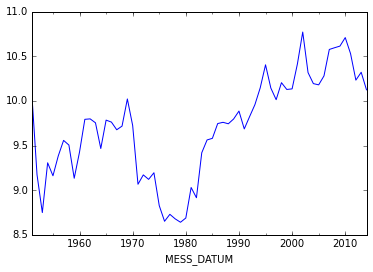

In [167]:
pd.rolling_mean(station_values_95th[23], window=10, min_periods=1).plot()

In [162]:
station_values_90th = station_values.resample('1A', how=lambda x: np.percentile(x, q=90))
station_values_90th.head()

STATIONS_ID,23,73,145,187,202,205,223,227,232,262,...,5785,5792,5803,5826,5831,5870,5906,5959,14303,14310
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1951-12-31,7.20,5.76,8.36,7.86,6.02,16.44,6.76,6.80,7.22,5.36,...,6.72,15.76,8.00,8.58,7.86,7.58,5.12,6.20,9.56,8.32
1952-12-31,5.75,6.50,8.30,7.50,6.45,16.90,5.50,8.30,6.85,7.90,...,9.25,18.75,10.85,7.00,5.90,7.70,6.40,7.45,9.45,8.00
1953-12-31,5.44,4.78,6.50,6.40,4.04,14.78,3.60,4.56,5.28,5.20,...,6.06,13.96,7.00,5.56,5.40,5.20,3.80,4.00,4.66,5.32
1954-12-31,7.06,7.96,9.50,9.98,6.40,21.04,7.16,8.32,7.66,7.48,...,7.76,18.02,10.38,8.06,7.46,7.22,6.26,8.10,7.40,9.44
1955-12-31,5.76,6.52,10.66,8.10,6.76,22.46,6.16,7.28,6.88,8.66,...,7.28,17.88,10.50,5.96,6.06,8.00,5.56,7.12,6.16,7.80


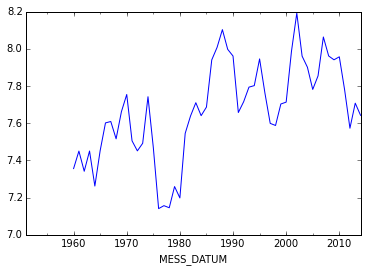

In [164]:
pd.rolling_mean(station_values_90th.T.mean(), window=10, min_periods=10).plot()

In [41]:
station_values_75th = station_values.resample('1A', how=lambda x: np.percentile(x, q=75))
station_values_75th.head()

STATIONS_ID,23,73,145,187,202,205,223,227,232,262,...,5785,5792,5803,5826,5831,5870,5906,5959,14303,14310
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1951-12-31,2.1,1.70,2.4,3.600,1.600,5.10,2.1,2.0,2.5,1.5,...,1.800,6.800,2.7,2.500,2.500,2.5,1.600,1.50,3.7,3.500
1952-12-31,2.7,2.45,3.2,3.175,2.575,9.25,2.6,3.0,2.7,3.0,...,3.175,9.125,4.0,2.875,2.875,3.3,1.875,2.95,3.1,3.975
1953-12-31,1.9,1.20,2.0,2.200,0.800,4.60,0.6,1.0,1.2,1.3,...,0.900,6.200,1.5,1.800,1.600,1.3,0.800,0.80,1.4,1.600
1954-12-31,2.7,2.90,2.9,3.700,2.400,7.90,2.3,2.9,3.0,2.2,...,2.400,7.200,3.5,3.100,3.100,3.0,2.500,3.00,2.8,4.400
1955-12-31,2.2,2.20,4.2,3.500,2.100,8.70,2.4,2.4,2.1,3.6,...,1.800,8.900,4.6,2.000,2.500,2.6,1.800,2.20,2.5,3.100


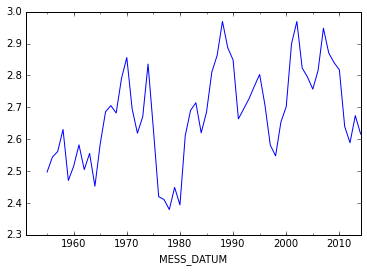

In [161]:
pd.rolling_mean(station_values_75th.T.mean(), window=10, min_periods=5).plot()

In [36]:
station_values_max = station_values.resample('1A', how=np.max)
station_values_max.head()

STATIONS_ID,23,73,145,187,202,205,223,227,232,262,...,5785,5792,5803,5826,5831,5870,5906,5959,14303,14310
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1951-12-31,29.6,32.0,41.5,33.8,50.7,66.4,28.5,40.2,37.7,30.1,...,52.9,51.3,35.7,31.9,46.0,43.4,17.6,35.2,32.7,29.2
1952-12-31,29.4,28.7,28.2,29.8,25.2,85.1,23.4,33.3,29.0,24.2,...,29.5,58.9,40.5,60.3,35.7,25.5,37.1,24.2,35.1,45.8
1953-12-31,27.6,47.4,42.0,26.1,41.2,64.6,18.5,35.0,35.5,59.0,...,49.8,37.7,46.0,40.3,20.5,35.0,26.6,27.3,19.8,52.7
1954-12-31,36.1,71.4,51.1,34.4,33.2,260.0,62.4,56.1,32.4,62.2,...,41.6,91.4,60.5,33.5,40.3,34.0,22.2,52.8,27.1,39.4
1955-12-31,25.2,51.9,57.7,29.1,30.2,92.4,40.8,25.4,46.3,40.9,...,44.2,64.6,55.0,27.0,29.0,35.2,72.0,47.0,32.7,57.0


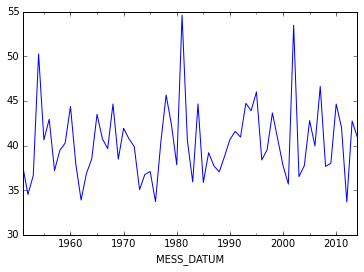

In [38]:
station_values_max.T.mean().plot()

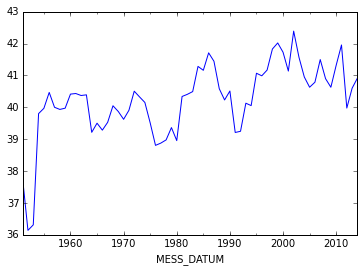

In [40]:
pd.rolling_mean(station_values_max.T.mean(), window=10, min_periods=1).plot()

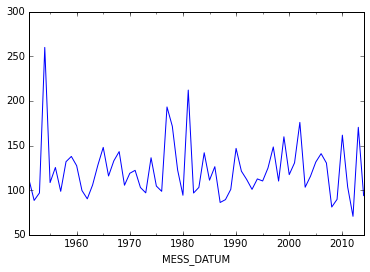

In [31]:
df_complete.set_index('MESS_DATUM').NIEDERSCHLAGSHOEHE.resample('1A', how=max).plot()

### Alle Niederschläge über 10 mm

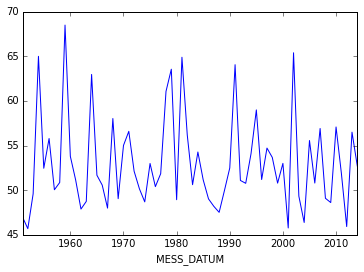

In [32]:
df_complete[df_complete.NIEDERSCHLAGSHOEHE > 10].groupby(df_complete.MESS_DATUM.dt.year).NIEDERSCHLAGSHOEHE.quantile(0.99).plot()

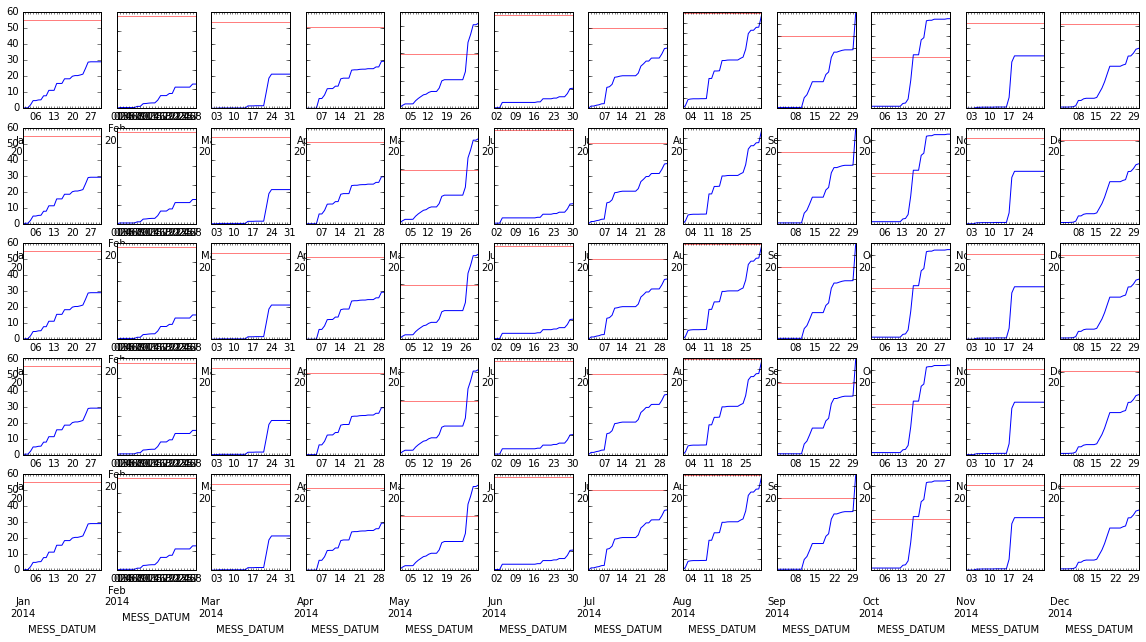

In [132]:
fig = plt.figure(figsize=(20, 10))

month_means = station_values.groupby([station_values.index.year, station_values.index.month]).sum().unstack().mean().unstack().T

x = 0
for i, station_id in enumerate(station_values.columns[:5]):
    station_id = station_values.columns[1]
    series = station_values[(station_values.index >= datetime(2014, 1, 1)) & (station_values.index < datetime(2015, 1, 1))][station_id]
    for month in month_means[station_id].index:
        x += 1
        ax = plt.subplot(5, 12, x)
        series[series.index.month == month].cumsum().plot(axes=ax, sharey=True)
        ax.axhline(y=month_means[station_id][month], xmin=0, xmax=31, c="r", linewidth=0.5, zorder=0)





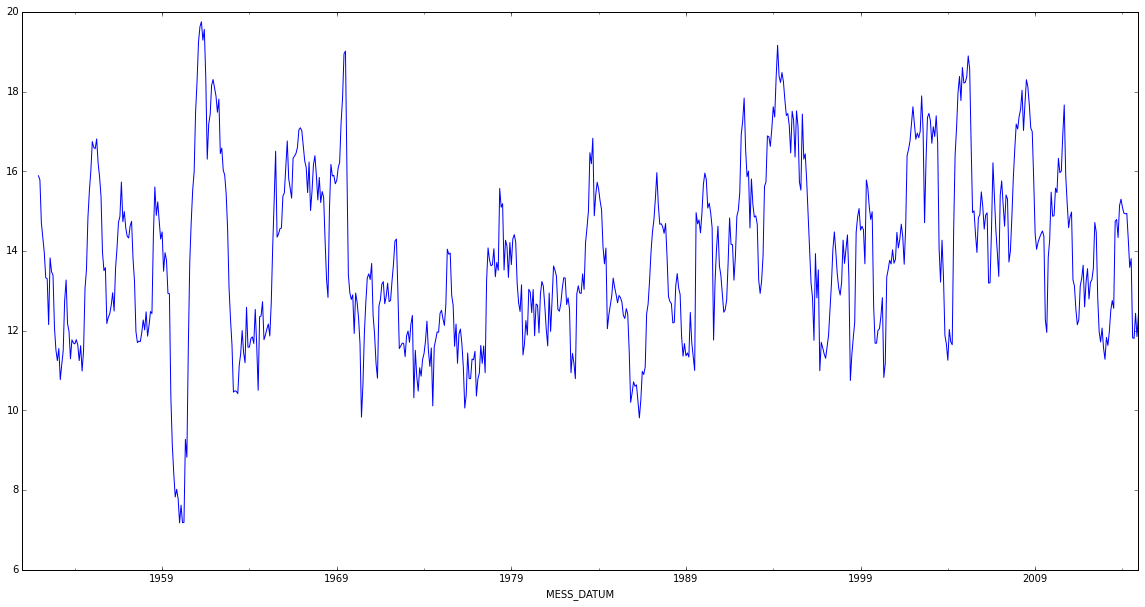

In [159]:
fig = plt.figure(figsize=(20, 10))
# ax = station_values[23].plot()

station_values_99th_m = station_values.resample('1M', how=lambda x: np.percentile(x, q=99))

# ax.axhline(y=, xmin=0, xmax=len(station_values[23]), c="r", linewidth=0.5, zorder=0)

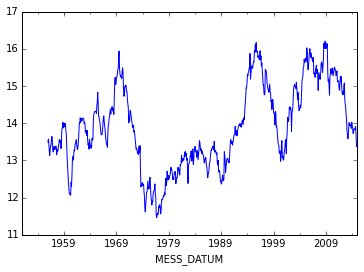

In [160]:
pd.rolling_mean(station_values_99th_m[23], window=5*12).plot()

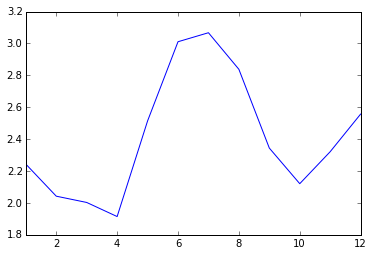

In [139]:
station_values.groupby(station_values.index.month).mean().mean(axis=1).plot()

### Example Münster Event

In [170]:
stations[stations.Stationsname.str.contains('Münster')]

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
1553,Nordrhein-Westfalen,01766,48,Münster/Osnabrück,2015-04-23,52.1346,7.6964,1989-10-01,1766,52.1346,7.6964,48
3025,Nordrhein-Westfalen,03404,62,Münster,1991-12-31,51.9494,7.5906,1891-01-01,3404,51.9494,7.5906,62
3026,Nordrhein-Westfalen,03405,57,Münster (Schleuse),2007-06-30,51.9833,7.6667,1951-01-01,3405,51.9833,7.6667,57
3027,Nordrhein-Westfalen,03407,320,"Münstereifel, Bad",2015-04-22,50.5485,6.7601,1931-01-01,3407,50.5485,6.7601,320
3028,Nordrhein-Westfalen,03408,348,"Münstereifel, Bad-Houverath",2006-12-31,50.5419,6.9024,1941-01-01,3408,50.5419,6.9024,348
3029,Bayern,03409,500,Münsterhausen,2005-12-31,48.3080,10.4566,1961-01-01,3409,48.3080,10.4566,500
3030,Rheinland-Pfalz,03410,255,Münstermaifeld,2015-04-22,50.2441,7.3600,1951-01-01,3410,50.2441,7.3600,255
3031,Bayern,03411,190,Münsterschwarzach,1970-12-30,49.8000,10.2333,1931-01-01,3411,49.8000,10.2333,190
3032,Baden-Württemberg,03412,456,Münstertal,2015-04-22,47.8691,7.8085,1931-01-01,3412,47.8691,7.8085,456


In [184]:
muenster_2014 = df[(df.STATIONS_ID == 1766) & (df.MESS_DATUM.dt.year == 2014)]
muenster_2014.head()

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSHOEHE_IND,SCHNEEHOEHE,eor
27892820,8858,1766,2014-01-01,3,0.0,6,0,eor
27892821,8859,1766,2014-01-02,3,0.7,6,0,eor
27892822,8860,1766,2014-01-03,3,5.1,6,0,eor
27892823,8861,1766,2014-01-04,3,1.7,6,0,eor
27892824,8862,1766,2014-01-05,3,0.0,0,0,eor


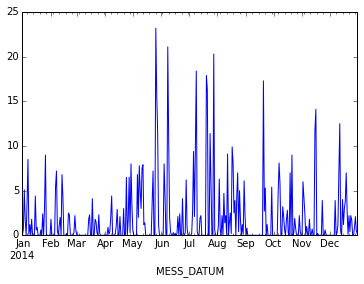

In [185]:
muenster_2014.set_index(muenster_2014.MESS_DATUM).NIEDERSCHLAGSHOEHE.plot()

In [191]:
muenster_2014[muenster_2014.MESS_DATUM.dt.month == 7]

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSHOEHE_IND,SCHNEEHOEHE,eor
27893001,9039,1766,2014-07-01,3,0.0,0,0,eor
27893002,9040,1766,2014-07-02,3,0.0,0,0,eor
27893003,9041,1766,2014-07-03,3,0.0,0,0,eor
27893004,9042,1766,2014-07-04,3,0.2,6,0,eor
27893005,9043,1766,2014-07-05,3,2.7,6,0,eor
27893006,9044,1766,2014-07-06,3,9.4,6,0,eor
27893007,9045,1766,2014-07-07,3,2.1,6,0,eor
27893008,9046,1766,2014-07-08,3,9.6,6,0,eor
27893009,9047,1766,2014-07-09,3,18.4,6,0,eor
27893010,9048,1766,2014-07-10,3,0.4,6,0,eor


In [186]:
df[(df.STATIONS_ID == 1766)].NIEDERSCHLAGSHOEHE.quantile(0.99)

20.078000000000067

### Data export

In [8]:
df_ex = df[['STATIONS_ID', 'NIEDERSCHLAGSHOEHE', 'MESS_DATUM']].merge(
        stations[['sid', 'lat', 'lng']], left_on='STATIONS_ID', right_on='sid', how='left')
df_ex.head()

,STATIONS_ID,NIEDERSCHLAGSHOEHE,MESS_DATUM,sid,lat,lng
0,1,0.0,1912-01-01,1.0,47.8413,8.8493
1,1,0.2,1912-01-02,1.0,47.8413,8.8493
2,1,0.0,1912-01-03,1.0,47.8413,8.8493
3,1,1.0,1912-01-04,1.0,47.8413,8.8493
4,1,2.1,1912-01-05,1.0,47.8413,8.8493


In [21]:
df_ex = df_ex.drop('sid', 1)
df_ex.to_csv('stern_export.csv', index=False)

In [24]:
len(df_ex)

267055